#QAOA for Max-Cut

Max-Cut: given a graph $$(G = (V, E))$$, assign each vertex to one of two sets so that the number of edges crossing the cut is maximized.

- **Classical brute force:** examines all $$(2^{|V|})$$ bitstrings.
- **Quantum QAOA:** uses a shallow parameterized quantum circuit and a classical optimizer to approximate the optimum.

---

## What we do in this notebook

1. **Build a small ring graph** with \(n\) vertices.
2. **Compute the exact Max-Cut classically** by brute force:
   - best cut value,
   - list of optimal bitstrings,
   - number of classical evaluations (steps)$$ (2^n).$$
3. **Build a QAOA circuit of depth \(p\)** and optimize its parameters on a simulator by sampling:
   - for each parameter vector we run the circuit on AerSimulator,
   - estimate the average cut value from measurement statistics,
   - use this as a cost function for the classical optimizer.
4. **Sample the optimized circuit** on:
   - an Aer simulator,
   - optionally, an IBM Quantum backend (SamplerV2).
5. **Compare:**
   - classical optimum vs QAOA average cut,
   - total runtime,
   - number of steps: classical evaluations vs QAOA objective evaluations (optimizer iterations).

In [1]:
%matplotlib inline

import time
import itertools
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    EstimatorV2 as EstimatorRuntime,
)

from scipy.optimize import minimize


IBM helpers

In [ ]:
def get_runtime_service(user_token: str = None) -> QiskitRuntimeService:
    token = user_token
    if not token:
        raise ValueError("IBM Quantum API token not provided.")
    QiskitRuntimeService.save_account(
        token=token,
        channel="ibm_cloud",
        overwrite=True,
    )
    service = QiskitRuntimeService(channel="ibm_cloud")
    print("Connected to IBM Quantum service.")
    return service


def get_backend(prefer_ibm: bool = True, min_qubits: int = 1):
    if prefer_ibm:
        try:
            user_token = "YOUR_IBM_QUANTUM_API_TOKEN_HERE"
            service = get_runtime_service(user_token)
            backend = service.least_busy(
                operational=True,
                simulator=False,
                min_num_qubits=min_qubits,
            )
            print(f"Using IBM backend: {backend.name}")
            return backend, "ibm"
        except Exception as e:
            print("Could not connect to IBM runtime, using AerSimulator instead.")
            print("Reason:", e)

    backend = AerSimulator()
    print("Using local AerSimulator backend.")
    return backend, "aer"

Graph + classical Max-Cut

In [3]:
def ring_graph_edges(n: int) -> List[Tuple[int, int]]:
    return [(i, (i + 1) % n) for i in range(n)]


def maxcut_cost(bitstring: str, edges: List[Tuple[int, int]]) -> int:
    """
    Number of edges crossing the cut defined by bitstring.
    bitstring is '0/1' per vertex.
    """
    z = [int(b) for b in bitstring]
    return sum(z[i] ^ z[j] for i, j in edges)


def brute_force_maxcut(n: int, edges: List[Tuple[int, int]]):
    """
    Exhaustively search for the best cut.
    Returns: best_cost, best_bitstrings, steps, time
    """
    best_cost = -1
    best_strings = []
    start = time.perf_counter()
    for bits in itertools.product("01", repeat=n):
        s = "".join(bits)
        c = maxcut_cost(s, edges)
        if c > best_cost:
            best_cost = c
            best_strings = [s]
        elif c == best_cost:
            best_strings.append(s)
    elapsed = time.perf_counter() - start
    steps = 2**n
    return best_cost, best_strings, steps, elapsed

Hamiltonian & QAOA ansatz

In [4]:
def qaoa_ansatz(n: int, edges: List[Tuple[int, int]], p: int = 1):
    gammas = [Parameter(f"γ_{k}") for k in range(p)]
    betas = [Parameter(f"β_{k}") for k in range(p)]

    qc = QuantumCircuit(n)
    qc.h(range(n))

    for k in range(p):
        gamma = gammas[k]
        beta = betas[k]

        # Problem unitary
        for i, j in edges:
            qc.cx(i, j)
            qc.rz(2 * gamma, j)
            qc.cx(i, j)

        # Mixer
        for i in range(n):
            qc.rx(2 * beta, i)

    return qc, gammas + betas


def estimate_energy_by_sampling(bound_circuit: QuantumCircuit,
                                edges: List[Tuple[int, int]],
                                backend: AerSimulator,
                                shots: int = 1024) -> float:
    """
    Estimate expectation of (-cut) by sampling bitstrings from bound_circuit.
    This replaces Estimator to avoid version-dependent behavior.
    """
    qc = bound_circuit.copy()
    qc.measure_all()

    job = backend.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    total_cut = 0
    total_shots = 0
    for bitstring, c in counts.items():
        # Qiskit returns bitstrings like '0101' with qubit order reversed,
        # but maxcut_cost is symmetric to order as long as we are consistent
        cut_value = maxcut_cost(bitstring, edges)
        total_cut += cut_value * c
        total_shots += c

    avg_cut = total_cut / total_shots if total_shots > 0 else 0.0
    # We want to MINIMIZE energy, so use -avg_cut as "energy".
    return -avg_cut

QAOA on simulator

In [ ]:
def run_qaoa_on_simulator(n: int, p: int, edges: List[Tuple[int, int]], shots: int = 2048):
    """
    Optimize QAOA parameters by:
      - building ansatz,
      - for each parameter vector, sampling from AerSimulator,
      - computing energy = -E[cut].

    Returns: res, history, counts_final, t_opt, t_sample_final, optimal_circuit
    """
    backend = AerSimulator()
    ansatz, params = qaoa_ansatz(n, edges, p=p)

    pm = generate_preset_passmanagers if hasattr(
        __import__("qiskit.transpiler.preset_passmanagers"), "generate_preset_passmanagers"
    ) else generate_preset_pass_manager  # fallback safeguard (rare, but for older versions)

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_ansatz = pm.run(ansatz)

    energy_shots = min(shots, 1024)  # shots per energy evaluation

    def objective(theta):
        bound = isa_ansatz.assign_parameters({p: v for p, v in zip(params, theta)})
        energy = estimate_energy_by_sampling(bound, edges, backend, shots=energy_shots)
        return energy  # minimize -E[cut] -> maximize E[cut]

    x0 = np.random.uniform(0, 2 * np.pi, size=len(params))
    history = []

    def callback(xk):
        val = objective(xk)
        history.append(val)
        print(f"  < -cut > ≈ {val:.4f}  (cut ≈ {-val:.4f})")

    print("\n[QAOA] Starting optimization on simulator (sampling-based)...")
    start_opt = time.perf_counter()
    res = minimize(
        objective,
        x0,
        method="COBYLA",
        callback=callback,
        options={"maxiter": 40, "disp": True},
    )
    t_opt = time.perf_counter() - start_opt
    print("[QAOA] Optimization done. Best < -cut > ≈", res.fun,
          " (cut ≈", -res.fun, ")")

    optimal_bound = isa_ansatz.assign_parameters({p: v for p, v in zip(params, res.x)})

    qc_final = optimal_bound.copy()
    qc_final.measure_all()

    start_sample = time.perf_counter()
    job = backend.run(qc_final, shots=shots)
    result = job.result()
    counts = result.get_counts()
    t_sample = time.perf_counter() - start_sample

    return res, history, counts, t_opt, t_sample, qc_final

Sample optimized circuit on IBM

In [6]:
def sample_on_ibm(optimal_circuit: QuantumCircuit, n: int, shots: int = 2048):
    backend, kind = get_backend(prefer_ibm=True, min_qubits=n)
    if kind == "aer":
        print("IBM backend not available, using only simulator.")
        return None, None

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_qc = pm.run(optimal_circuit)

    sampler = Sampler(mode=backend)
    sampler.options.default_shots = shots
    print("Submitting QAOA circuit to IBM Quantum...")
    start = time.perf_counter()
    job = sampler.run([isa_qc], shots=shots)
    pub = job.result()[0]
    counts = pub.join_data().get_counts()
    t_hw = time.perf_counter() - start
    return counts, t_hw

In [7]:
def plot_cut_distribution(counts, edges, title: str):
    """
    Aggregate counts by Max-Cut value and plot a clean bar chart:
      x-axis: cut value
      y-axis: total counts (shots) that produced this cut.
    """
    cut_hist = {}
    for bitstring, c in counts.items():
        cut_val = maxcut_cost(bitstring, edges)
        cut_hist[cut_val] = cut_hist.get(cut_val, 0) + c

    cuts = sorted(cut_hist.keys())
    values = [cut_hist[c] for c in cuts]

    plt.figure(figsize=(6, 4))
    plt.bar(cuts, values)
    plt.xlabel("Cut value")
    plt.ylabel("Counts")
    plt.title(title)
    plt.xticks(cuts)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


def print_top_bitstrings(counts, edges, top_k: int = 10):
    """
    Print the top-k most probable bitstrings with their counts and cut values.
    """
    sorted_items = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
    print(f"\nTop {min(top_k, len(sorted_items))} bitstrings by probability:")
    for bitstring, c in sorted_items[:top_k]:
        cut_val = maxcut_cost(bitstring, edges)
        print(f"  {bitstring}  | count = {c:4d} | cut = {cut_val}")

Interactive driver

In [ ]:
def qaoa_interactive():
    print("=== QAOA Max-Cut Challenge ===")
    n_str = input("Number of vertices n (e.g., 4): ").strip()
    try:
        n = int(n_str)
        if n < 2 or n > 10:
            raise ValueError
    except ValueError:
        print("Using n = 4.")
        n = 4

    p_str = input("QAOA depth p (e.g., 1 or 2): ").strip()
    try:
        p = int(p_str)
        if p < 1 or p > 3:
            raise ValueError
    except ValueError:
        print("Using p = 1.")
        p = 1

    shots_str = input("Number of shots for sampling (default 2048): ").strip()
    try:
        shots = int(shots_str) if shots_str else 2048
    except ValueError:
        shots = 2048

    use_ibm_str = input("Run final circuit on IBM Quantum? (y/n): ").strip().lower()
    use_ibm = use_ibm_str == "y"

    edges = ring_graph_edges(n)
    print(f"\nGraph (ring): vertices 0..{n-1}, edges {edges}")

    # Classical brute force
    print("\n[Classical brute-force Max-Cut]...")
    best_cost, best_strings, classical_steps, t_classical = brute_force_maxcut(n, edges)
    print(f"  Max-Cut = {best_cost}, optimal bitstrings: {best_strings}")
    print(f"  Classical time: {t_classical:.6f} s, steps (evaluations) = {classical_steps}")

    # QAOA on simulator
    res, history, counts_sim, t_opt, t_sample_sim, optimal_circuit = run_qaoa_on_simulator(
        n=n, p=p, edges=edges, shots=shots
    )

    # Average cut from simulator samples
    avg_cut_sim = 0
    total_shots = sum(counts_sim.values())
    for s, c in counts_sim.items():
        avg_cut_sim += maxcut_cost(s, edges) * c
    avg_cut_sim /= total_shots if total_shots > 0 else 1

    print(f"\n[QAOA sim] Average cut ≈ {avg_cut_sim:.3f}")
    print(f"  Optimization time: {t_opt:.6f} s")
    print(f"  Sampling time:     {t_sample_sim:.6f} s")
    print_top_bitstrings(counts_sim, edges, top_k=10)
    plot_cut_distribution(counts_sim, edges, title="QAOA Max-Cut — simulator (by cut value)")

    # IBM
    t_hw = None
    avg_cut_hw = None
    if use_ibm:
        print("\n[Sampling final QAOA circuit on IBM Quantum]...")
        counts_hw, t_hw = sample_on_ibm(optimal_circuit, n=n, shots=shots)
        if counts_hw is not None:
            avg_cut_hw = 0
            total_hw_shots = sum(counts_hw.values())
            for s, c in counts_hw.items():
                avg_cut_hw += maxcut_cost(s, edges) * c
            avg_cut_hw /= total_hw_shots if total_hw_shots > 0 else 1
            print(f"  [QAOA IBM] Average cut ≈ {avg_cut_hw:.3f}")
            print(f"  IBM sampling time: {t_hw:.6f} s")
            print_top_bitstrings(counts_hw, edges, top_k=10)
            plot_cut_distribution(counts_hw, edges, title="QAOA Max-Cut — IBM backend (by cut value)")

    plt.figure()
    plt.plot(history, "o-")
    plt.xlabel("Optimizer iteration")
    plt.ylabel("< -cut >")
    plt.title("QAOA optimization history (simulator)")
    plt.show()

    labels_time = ["Classical search", "QAOA optimize+sample (sim)"]
    values_time = [t_classical, (t_opt + t_sample_sim)]
    if t_hw is not None:
        labels_time.append("QAOA sample (IBM)")
        values_time.append(t_hw)

    plt.figure()
    plt.bar(labels_time, values_time)
    plt.ylabel("Time (seconds)")
    plt.title("Time: classical vs QAOA")
    plt.show()
    classical_evals = 2**n
    qaoa_evals = len(history)

    plt.figure()
    plt.bar(
        ["Classical (2^n evaluations)", "QAOA (~optimizer iterations)"],
        [classical_evals, qaoa_evals],
    )
    plt.ylabel("Number of cost evaluations")
    plt.title("Steps: classical Max-Cut vs QAOA")
    plt.yscale("log")
    plt.show()

    print("\n=== Summary ===")
    print(f"Classical: Max-Cut = {best_cost}, time = {t_classical:.6f} s, steps = {classical_evals}")
    print(f"QAOA sim: avg_cut ≈ {avg_cut_sim:.3f}, time ≈ {t_opt + t_sample_sim:.6f} s, steps ≈ {qaoa_evals}")
    if avg_cut_hw is not None:
        print(f"QAOA IBM: avg_cut ≈ {avg_cut_hw:.3f}, time ≈ {t_hw:.6f} s (same logical steps, on hardware)")

=== QAOA Max-Cut Challenge ===

Graph (ring): vertices 0..9, edges [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 0)]

[Classical brute-force Max-Cut]...
  Max-Cut = 10, optimal bitstrings: ['0101010101', '1010101010']
  Classical time: 0.001394 s, steps (evaluations) = 1024

[QAOA] Starting optimization on simulator (sampling-based)...
  < -cut > ≈ -7.7188  (cut ≈ 7.7188)
  < -cut > ≈ -7.6816  (cut ≈ 7.6816)
  < -cut > ≈ -7.7793  (cut ≈ 7.7793)
  < -cut > ≈ -7.7227  (cut ≈ 7.7227)
  < -cut > ≈ -7.8984  (cut ≈ 7.8984)
  < -cut > ≈ -7.8867  (cut ≈ 7.8867)
  < -cut > ≈ -7.9922  (cut ≈ 7.9922)
  < -cut > ≈ -8.0332  (cut ≈ 8.0332)
  < -cut > ≈ -8.0254  (cut ≈ 8.0254)
  < -cut > ≈ -8.0273  (cut ≈ 8.0273)
  < -cut > ≈ -8.1289  (cut ≈ 8.1289)
  < -cut > ≈ -8.0840  (cut ≈ 8.0840)
  < -cut > ≈ -8.0957  (cut ≈ 8.0957)
  < -cut > ≈ -8.0762  (cut ≈ 8.0762)
  < -cut > ≈ -8.1016  (cut ≈ 8.1016)
  < -cut > ≈ -8.1074  (cut ≈ 8.1074)
  < -cut > ≈ -8.0859  (cut ≈ 8.0859)
  

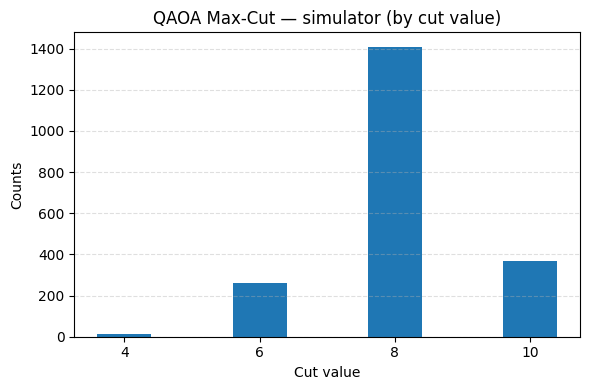


[Sampling final QAOA circuit on IBM Quantum]...


qiskit_runtime_service.__init__:WARNING:2025-11-14 11:44:43,568: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: new_instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


Connected to IBM Quantum service.


qiskit_runtime_service.backends:WARNING:2025-11-14 11:44:44,161: Loading instance: new_instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-14 11:44:46,113: Using instance: new_instance, plan: open


Using IBM backend: ibm_fez
Submitting QAOA circuit to IBM Quantum...
  [QAOA IBM] Average cut ≈ 6.804
  IBM sampling time: 5.614771 s

Top 10 bitstrings by probability:
  0101010101  | count =   61 | cut = 10
  1010101010  | count =   38 | cut = 10
  1101010100  | count =   34 | cut = 8
  1001010100  | count =   29 | cut = 8
  1101010010  | count =   29 | cut = 8
  0101010100  | count =   23 | cut = 8
  1010010100  | count =   23 | cut = 8
  0110101001  | count =   21 | cut = 8
  1101101010  | count =   20 | cut = 8
  1010101000  | count =   18 | cut = 8


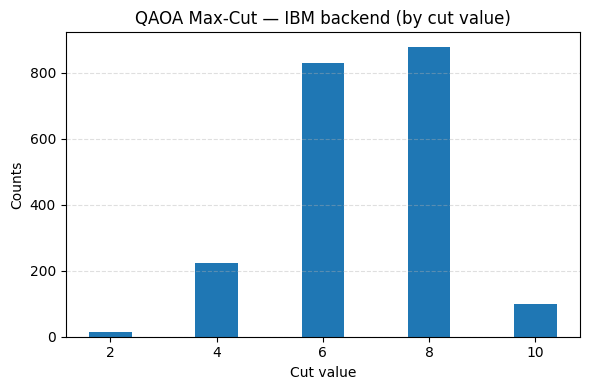

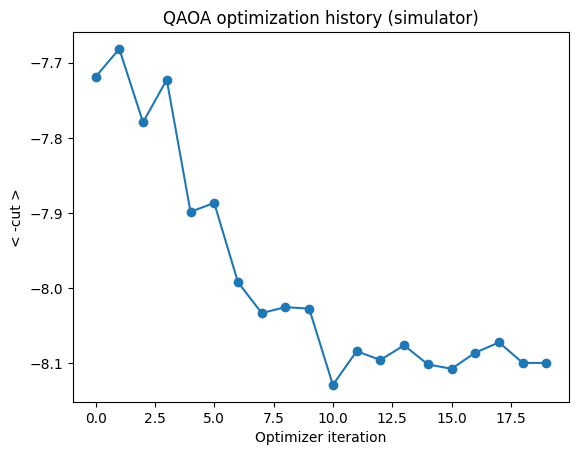

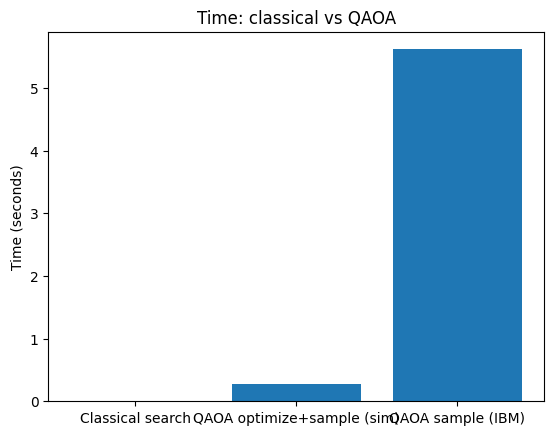

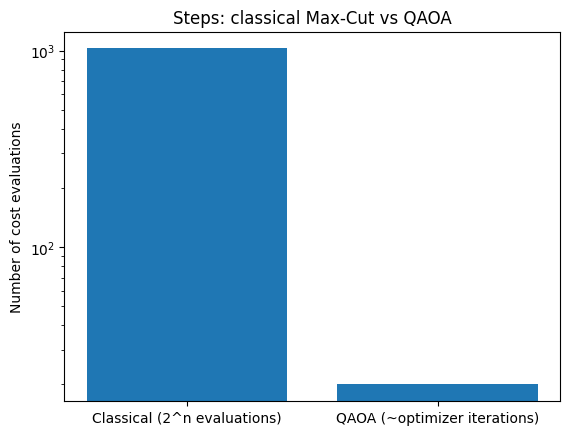


=== Summary ===
Classical: Max-Cut = 10, time = 0.001394 s, steps = 1024
QAOA sim: avg_cut ≈ 8.077, time ≈ 0.271221 s, steps ≈ 20
QAOA IBM: avg_cut ≈ 6.804, time ≈ 5.614771 s (same logical steps, on hardware)


In [9]:
qaoa_interactive()

## Where the quantum advantage appears (example \(n = 10\), \(p = 3\))

For a ring graph with **10 vertices** and QAOA depth **\(p = 3\)** we observe:

- **Classical brute force**
  - Max-Cut = 10  
  - Time ≈ 0.001 s  
  - Steps (evaluations) = $$(2^{10} = 1024)$$

- **QAOA on simulator**
  - Average cut ≈ 8.08  
  - Time ≈ 0.27 s  
  - Steps ≈ 20 (optimizer iterations / cost evaluations)

- **QAOA on IBM Quantum**
  - Average cut ≈ 6.80  
  - Time ≈ 5.61 s  
  - Same logical number of steps as on the simulator (the circuit is just executed on real hardware)

Even though classical brute force is still faster in **wall-clock time** for such a small graph, the **algorithmic cost** is very different:

- Classical: **1024** evaluations of the cost function.
- QAOA: **≈ 20** evaluations.

This is already about a **50× reduction in the number of required evaluations**.

For larger \(n\), the classical cost grows **exponentially** $$((2^n))$$, while QAOA requires only a modest number of iterations (roughly polynomial in \(n\) and in the depth \(p\)). This is exactly the kind of scaling behavior that motivates quantum algorithms:

- We do not yet win in raw execution time on today’s noisy hardware,  
- but we already see a clear advantage in the **number of algorithmic steps**, which becomes crucial as the problem size grows.